In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.io as spio
import scipy.sparse as sp

import regex as re


In [2]:
#Load reference library dataframe and build barcode dictionary

library_df = pd.read_csv("apa_100_variants_rev2_20220621_pred.csv", sep='\t')

#Build dictionary (double-mutation support)
bases = ['A', 'C', 'G', 'T']

barcode_dict = {}
sequences = []
for i, [_, row] in enumerate(library_df.iterrows()) :
    bc = row['ref_barcode']
    
    sequences.append(row['ref_seq'])
    
    barcode_dict[bc] = i
    for pos1 in range(len(bc)) :
        for pos2 in range(pos1, len(bc)) :
            for b1 in bases :
                for b2 in bases :
                    bc_mut = bc[:pos1] + b1 + bc[pos1+1:pos2] + b2 + bc[pos2+1:]
                    
                    if bc_mut in barcode_dict and barcode_dict[bc_mut] != i :
                        print("[ERROR] Barcode dictionary collision.")
                    else :
                        barcode_dict[bc_mut] = i

print("len(barcode_dict) = " + str(len(barcode_dict)))


len(barcode_dict) = 201500


In [3]:
barcode_dict

{'GATGCAGCTGGCTATCATGA': 0,
 'AAATGCAGCTGGCTATCATGA': 0,
 'ACATGCAGCTGGCTATCATGA': 0,
 'AGATGCAGCTGGCTATCATGA': 0,
 'ATATGCAGCTGGCTATCATGA': 0,
 'CAATGCAGCTGGCTATCATGA': 0,
 'CCATGCAGCTGGCTATCATGA': 0,
 'CGATGCAGCTGGCTATCATGA': 0,
 'CTATGCAGCTGGCTATCATGA': 0,
 'GAATGCAGCTGGCTATCATGA': 0,
 'GCATGCAGCTGGCTATCATGA': 0,
 'GGATGCAGCTGGCTATCATGA': 0,
 'GTATGCAGCTGGCTATCATGA': 0,
 'TAATGCAGCTGGCTATCATGA': 0,
 'TCATGCAGCTGGCTATCATGA': 0,
 'TGATGCAGCTGGCTATCATGA': 0,
 'TTATGCAGCTGGCTATCATGA': 0,
 'AATGCAGCTGGCTATCATGA': 0,
 'ACTGCAGCTGGCTATCATGA': 0,
 'AGTGCAGCTGGCTATCATGA': 0,
 'ATTGCAGCTGGCTATCATGA': 0,
 'CATGCAGCTGGCTATCATGA': 0,
 'CCTGCAGCTGGCTATCATGA': 0,
 'CGTGCAGCTGGCTATCATGA': 0,
 'CTTGCAGCTGGCTATCATGA': 0,
 'GCTGCAGCTGGCTATCATGA': 0,
 'GGTGCAGCTGGCTATCATGA': 0,
 'GTTGCAGCTGGCTATCATGA': 0,
 'TATGCAGCTGGCTATCATGA': 0,
 'TCTGCAGCTGGCTATCATGA': 0,
 'TGTGCAGCTGGCTATCATGA': 0,
 'TTTGCAGCTGGCTATCATGA': 0,
 'AAAGCAGCTGGCTATCATGA': 0,
 'AACGCAGCTGGCTATCATGA': 0,
 'AAGGCAGCTGGCTATCATGA': 0,
 'CA

In [7]:
#Parse and map RNA sequencing reads

save_suffix = "_var_repl_2_hek293_v3"

r1_name = "unprocessed_data/HEK_V2_trimmed.fastq"
r2_name = "unprocessed_data/HEK-V2_umi_trimmed.fastq"

polya_regexp = re.compile(r"AAAAA(AAAAAAAAAAAAAAA){s<=2}")
distal_regexp = re.compile(r"(GCCTCGACTGTGCCTTCTAG){s<=2}")

def _hamming(s1, s2) :
    
    d = 0.
    for j in range(len(s1)) :
        if s1[j] != s2[j] :
            d += 1.
    
    return d

max_pos = 176

umi_dict = {}
umi_n_muts = 0

bases = ['A', 'C', 'G', 'T']

cuts = np.zeros((len(library_df), 206))

f1 = open(r1_name, 'rt')
f2 = open(r2_name, 'rt')

#Iterate through reads sequenctially (r1 and r2)

r1_counter = 0
while True :
    
    #Read 1
    id1 = f1.readline().strip()
    
    #Check for end-of-file
    if len(id1) == 0 :
        break
    
    r1 = f1.readline().strip()
    s1 = f1.readline().strip()
    q1 = f1.readline().strip()
    
    #Read 2
    id2 = f2.readline().strip()
    r2 = f2.readline().strip()
    s2 = f2.readline().strip()
    q2 = f2.readline().strip()
    
    if r1_counter % 10000 == 0 :
        print("Processing read " + str(r1_counter) + "...")
    
    r1_counter += 1
    
    #Map read to library member
    bc = r1[:20]
    
    lib_i = -1
    if bc in barcode_dict :
        lib_i = barcode_dict[bc]
    
    if lib_i == -1 :
        continue
    
    if umi_n_muts == 0 :
        bc = sequences[lib_i][:20]
    
    #Determine if we have seen this umi before, otherwise mark as visited
    umi = r2[:8]
    
    if bc not in umi_dict :
        umi_dict[bc] = {}
    
    umi_visited = False
    if umi in umi_dict[bc] :
        umi_visited = True
    elif umi_n_muts == 1 :
        for pos1 in range(len(umi)) :
            for b1 in bases :
                umi_mut = umi[:pos1] + b1 + umi[pos1+1:]
                if umi_mut in umi_dict[bc] :
                    umi_visited = True
                    break
            if umi_visited :
                break
    elif umi_n_muts == 2 :
        for pos1 in range(len(umi)) :
            for pos2 in range(pos1, len(umi)) :
                for b1 in bases :
                    for b2 in bases :
                        umi_mut = umi[:pos1] + b1 + umi[pos1+1:pos2] + b2 + umi[pos2+1:]
                        if umi_mut in umi_dict[bc] :
                            umi_visited = True
                            break
                    if umi_visited :
                        break
                if umi_visited :
                    break
            if umi_visited :
                break
    
    #Skip if umi already seen
    if umi_visited :
        continue
    
    #Determine polyA position (or alternative if the read is distally polyadenylated)
    polya_match = re.search(polya_regexp, r1)
    
    polya_pos = -1
    if polya_match is not None and polya_match.span()[0] < max_pos :
        polya_pos = polya_match.span()[0]
    
    #Determine if distal read
    is_distal = False
    distal_match = re.search(distal_regexp, r1[209-5:209+20+5])
    
    if distal_match is not None :
        is_distal = True
    
    #Aggregate read-position occurrence counts
    if is_distal :
        cuts[lib_i, -1] += 1.
        
        #Mark as seen and proceed
        umi_dict[bc][umi] = True
        
    elif polya_pos != -1 and polya_pos >= 30 :
        
        #Perform hamming-based consistency check against reference of region upstream of cleavage
        
        hamming_dist = _hamming(sequences[lib_i][polya_pos-20:polya_pos], r1[polya_pos-20:polya_pos])
        
        if hamming_dist <= 3 :
            cuts[lib_i, polya_pos] += 1.

            #Mark as seen and proceed
            umi_dict[bc][umi] = True

f1.close()
f2.close()

print("Done!")

print("Total # of unique-UMI reads = " + str(int(np.sum(cuts))))

#Store processed read-position count matrix
np.save('apa_oligo_2022' + save_suffix + '_umi_mut_' + str(umi_n_muts) + '_cuts', cuts)


Processing read 0...
Processing read 10000...
Processing read 20000...
Processing read 30000...
Processing read 40000...
Processing read 50000...
Processing read 60000...
Processing read 70000...
Processing read 80000...
Processing read 90000...
Processing read 100000...
Processing read 110000...
Processing read 120000...
Processing read 130000...
Done!
Total # of unique-UMI reads = 86492


In [4]:
#Load processed read count data

ref_cuts_repl_1 = np.load("apa_oligo_2022_ref_repl_1_hek293_v3_umi_mut_0_cuts.npy")
var_cuts_repl_1 = np.load("apa_oligo_2022_var_repl_1_hek293_v3_umi_mut_0_cuts.npy")

ref_cuts_repl_2 = np.load("apa_oligo_2022_ref_repl_2_hek293_v3_umi_mut_0_cuts.npy")
var_cuts_repl_2 = np.load("apa_oligo_2022_var_repl_2_hek293_v3_umi_mut_0_cuts.npy")

#Pooled counts

ref_cuts_pooled = ref_cuts_repl_1 + ref_cuts_repl_2
var_cuts_pooled = var_cuts_repl_1 + var_cuts_repl_2


In [5]:
#Augment library file with measured isoform summary statistics

pseudo_c = 1.

#Replicate 1
library_df['ref_count_77_127_repl_1'] = np.sum(ref_cuts_repl_1[:, 77:127], axis=-1)
library_df['ref_count_0_205_repl_1'] = np.sum(ref_cuts_repl_1[:, 0:205], axis=-1)
library_df['ref_count_total_repl_1'] = np.sum(ref_cuts_repl_1, axis=-1)
library_df['ref_logit_77_127_repl_1'] = np.log(
    ((library_df['ref_count_77_127_repl_1'] + pseudo_c) / (library_df['ref_count_total_repl_1'] + 2. * pseudo_c)) / (1. - ((library_df['ref_count_77_127_repl_1'] + pseudo_c) / (library_df['ref_count_total_repl_1'] + 2. * pseudo_c)))
)
library_df['ref_logit_0_205_repl_1'] = np.log(
    ((library_df['ref_count_0_205_repl_1'] + pseudo_c) / (library_df['ref_count_total_repl_1'] + 2. * pseudo_c)) / (1. - ((library_df['ref_count_0_205_repl_1'] + pseudo_c) / (library_df['ref_count_total_repl_1'] + 2. * pseudo_c)))
)

library_df['var_count_77_127_repl_1'] = np.sum(var_cuts_repl_1[:, 77:127], axis=-1)
library_df['var_count_0_205_repl_1'] = np.sum(var_cuts_repl_1[:, 0:205], axis=-1)
library_df['var_count_total_repl_1'] = np.sum(var_cuts_repl_1, axis=-1)
library_df['var_logit_77_127_repl_1'] = np.log(
    ((library_df['var_count_77_127_repl_1'] + pseudo_c) / (library_df['var_count_total_repl_1'] + 2. * pseudo_c)) / (1. - ((library_df['var_count_77_127_repl_1'] + pseudo_c) / (library_df['var_count_total_repl_1'] + 2. * pseudo_c)))
)
library_df['var_logit_0_205_repl_1'] = np.log(
    ((library_df['var_count_0_205_repl_1'] + pseudo_c) / (library_df['var_count_total_repl_1'] + 2. * pseudo_c)) / (1. - ((library_df['var_count_0_205_repl_1'] + pseudo_c) / (library_df['var_count_total_repl_1'] + 2. * pseudo_c)))
)

library_df['delta_logodds_true_77_127_repl_1'] = library_df['var_logit_77_127_repl_1'] - library_df['ref_logit_77_127_repl_1']
library_df['delta_logodds_true_0_205_repl_1'] = library_df['var_logit_0_205_repl_1'] - library_df['ref_logit_0_205_repl_1']

#Replicate 2
library_df['ref_count_77_127_repl_2'] = np.sum(ref_cuts_repl_2[:, 77:127], axis=-1)
library_df['ref_count_0_205_repl_2'] = np.sum(ref_cuts_repl_2[:, 0:205], axis=-1)
library_df['ref_count_total_repl_2'] = np.sum(ref_cuts_repl_2, axis=-1)
library_df['ref_logit_77_127_repl_2'] = np.log(
    ((library_df['ref_count_77_127_repl_2'] + pseudo_c) / (library_df['ref_count_total_repl_2'] + 2. * pseudo_c)) / (1. - ((library_df['ref_count_77_127_repl_2'] + pseudo_c) / (library_df['ref_count_total_repl_2'] + 2. * pseudo_c)))
)
library_df['ref_logit_0_205_repl_2'] = np.log(
    ((library_df['ref_count_0_205_repl_2'] + pseudo_c) / (library_df['ref_count_total_repl_2'] + 2. * pseudo_c)) / (1. - ((library_df['ref_count_0_205_repl_2'] + pseudo_c) / (library_df['ref_count_total_repl_2'] + 2. * pseudo_c)))
)

library_df['var_count_77_127_repl_2'] = np.sum(var_cuts_repl_2[:, 77:127], axis=-1)
library_df['var_count_0_205_repl_2'] = np.sum(var_cuts_repl_2[:, 0:205], axis=-1)
library_df['var_count_total_repl_2'] = np.sum(var_cuts_repl_2, axis=-1)
library_df['var_logit_77_127_repl_2'] = np.log(
    ((library_df['var_count_77_127_repl_2'] + pseudo_c) / (library_df['var_count_total_repl_2'] + 2. * pseudo_c)) / (1. - ((library_df['var_count_77_127_repl_2'] + pseudo_c) / (library_df['var_count_total_repl_2'] + 2. * pseudo_c)))
)
library_df['var_logit_0_205_repl_2'] = np.log(
    ((library_df['var_count_0_205_repl_2'] + pseudo_c) / (library_df['var_count_total_repl_2'] + 2. * pseudo_c)) / (1. - ((library_df['var_count_0_205_repl_2'] + pseudo_c) / (library_df['var_count_total_repl_2'] + 2. * pseudo_c)))
)

library_df['delta_logodds_true_77_127_repl_2'] = library_df['var_logit_77_127_repl_2'] - library_df['ref_logit_77_127_repl_2']
library_df['delta_logodds_true_0_205_repl_2'] = library_df['var_logit_0_205_repl_2'] - library_df['ref_logit_0_205_repl_2']

#Pooled replicates
library_df['ref_count_77_127_repl_pooled'] = np.sum(ref_cuts_pooled[:, 77:127], axis=-1)
library_df['ref_count_0_205_repl_pooled'] = np.sum(ref_cuts_pooled[:, 0:205], axis=-1)
library_df['ref_count_total_repl_pooled'] = np.sum(ref_cuts_pooled, axis=-1)
library_df['ref_logit_77_127_repl_pooled'] = np.log(
    ((library_df['ref_count_77_127_repl_pooled'] + pseudo_c) / (library_df['ref_count_total_repl_pooled'] + 2. * pseudo_c)) / (1. - ((library_df['ref_count_77_127_repl_pooled'] + pseudo_c) / (library_df['ref_count_total_repl_pooled'] + 2. * pseudo_c)))
)
library_df['ref_logit_0_205_repl_pooled'] = np.log(
    ((library_df['ref_count_0_205_repl_pooled'] + pseudo_c) / (library_df['ref_count_total_repl_pooled'] + 2. * pseudo_c)) / (1. - ((library_df['ref_count_0_205_repl_pooled'] + pseudo_c) / (library_df['ref_count_total_repl_pooled'] + 2. * pseudo_c)))
)

library_df['var_count_77_127_repl_pooled'] = np.sum(var_cuts_pooled[:, 77:127], axis=-1)
library_df['var_count_0_205_repl_pooled'] = np.sum(var_cuts_pooled[:, 0:205], axis=-1)
library_df['var_count_total_repl_pooled'] = np.sum(var_cuts_pooled, axis=-1)
library_df['var_logit_77_127_repl_pooled'] = np.log(
    ((library_df['var_count_77_127_repl_pooled'] + pseudo_c) / (library_df['var_count_total_repl_pooled'] + 2. * pseudo_c)) / (1. - ((library_df['var_count_77_127_repl_pooled'] + pseudo_c) / (library_df['var_count_total_repl_pooled'] + 2. * pseudo_c)))
)
library_df['var_logit_0_205_repl_pooled'] = np.log(
    ((library_df['var_count_0_205_repl_pooled'] + pseudo_c) / (library_df['var_count_total_repl_pooled'] + 2. * pseudo_c)) / (1. - ((library_df['var_count_0_205_repl_pooled'] + pseudo_c) / (library_df['var_count_total_repl_pooled'] + 2. * pseudo_c)))
)

library_df['delta_logodds_true_77_127_repl_pooled'] = library_df['var_logit_77_127_repl_pooled'] - library_df['ref_logit_77_127_repl_pooled']
library_df['delta_logodds_true_0_205_repl_pooled'] = library_df['var_logit_0_205_repl_pooled'] - library_df['ref_logit_0_205_repl_pooled']


In [6]:
#Cache measurements in dataframe

library_df.to_csv("apa_100_variants_rev2_20220621_hek293_v3_umi_mut_0.csv", sep='\t')


In [6]:
#Compute cleavage probabilities

ref_cut_prob_repl_1 = ref_cuts_repl_1 / np.sum(ref_cuts_repl_1, axis=1)[:, None]
var_cut_prob_repl_1 = var_cuts_repl_1 / np.sum(var_cuts_repl_1, axis=1)[:, None]

ref_cut_prob_repl_2 = ref_cuts_repl_2 / np.sum(ref_cuts_repl_2, axis=1)[:, None]
var_cut_prob_repl_2 = var_cuts_repl_2 / np.sum(var_cuts_repl_2, axis=1)[:, None]

ref_cut_prob_pooled = ref_cuts_pooled / np.sum(ref_cuts_pooled, axis=1)[:, None]
var_cut_prob_pooled = var_cuts_pooled / np.sum(var_cuts_pooled, axis=1)[:, None]


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


delta_logodds (repl 1) = 1.0482
delta_logodds (repl 2) = 0.7639
delta_logodds (pooled) = 0.9385


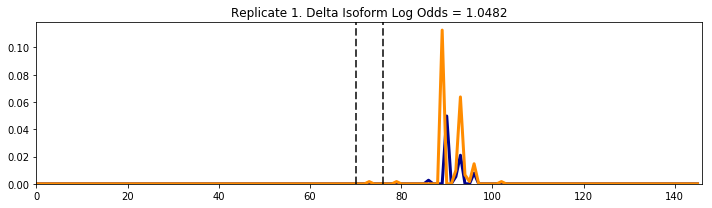

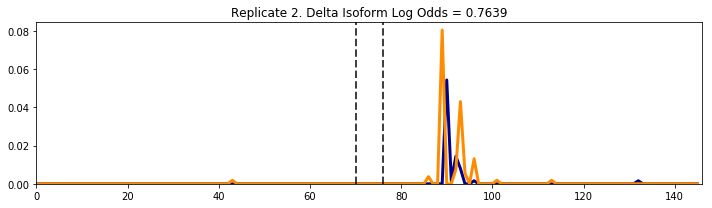

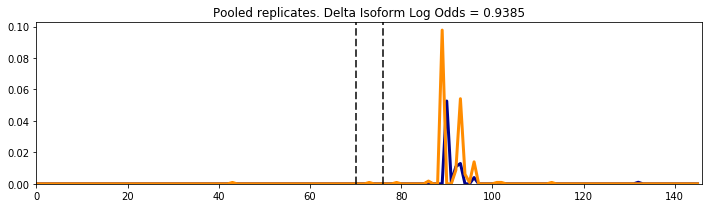

In [8]:
#Control: F2 variant (creation of new cutsite -1bp relative to reference)

save_figs = True
fig_name = "F2_control_profile_hek293"

test_ix = 9

#Plot range
plot_start = 0
plot_end = 146

#Isoform definition
cut_start = 77
cut_end = 127

c_ref_1 = ref_cut_prob_repl_1[test_ix, :]
c_var_1 = var_cut_prob_repl_1[test_ix, :]

c_ref_2 = ref_cut_prob_repl_2[test_ix, :]
c_var_2 = var_cut_prob_repl_2[test_ix, :]

c_ref_pooled = ref_cut_prob_pooled[test_ix, :]
c_var_pooled = var_cut_prob_pooled[test_ix, :]

delta_logodds_1 = np.log(np.sum(c_var_1[77:127]) / (1. - np.sum(c_var_1[77:127]))) - np.log(np.sum(c_ref_1[77:127]) / (1. - np.sum(c_ref_1[77:127])))
delta_logodds_2 = np.log(np.sum(c_var_2[77:127]) / (1. - np.sum(c_var_2[77:127]))) - np.log(np.sum(c_ref_2[77:127]) / (1. - np.sum(c_ref_2[77:127])))
delta_logodds_pooled = np.log(np.sum(c_var_pooled[77:127]) / (1. - np.sum(c_var_pooled[77:127]))) - np.log(np.sum(c_ref_pooled[77:127]) / (1. - np.sum(c_ref_pooled[77:127])))

print("delta_logodds (repl 1) = " + str(round(delta_logodds_1, 4)))
print("delta_logodds (repl 2) = " + str(round(delta_logodds_2, 4)))
print("delta_logodds (pooled) = " + str(round(delta_logodds_pooled, 4)))

#Plot replicate 1 profile
f = plt.figure(figsize=(10, 3))

plt.plot(c_ref_1[plot_start: plot_end], color='darkblue', linewidth=3)
plt.plot(c_var_1[plot_start: plot_end], color='darkorange', linewidth=3)

plt.axvline(x=70, linewidth=2, linestyle='--', color='black', alpha=0.75)
plt.axvline(x=76, linewidth=2, linestyle='--', color='black', alpha=0.75)

plt.xlim(plot_start, plot_end)
plt.ylim(0.)

plt.title("Replicate 1. Delta Isoform Log Odds = " + str(round(delta_logodds_1, 4)))

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_repl_1.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_repl_1.eps")

plt.show()

#Plot replicate 2 profile
f = plt.figure(figsize=(10, 3))

plt.plot(c_ref_2[plot_start: plot_end], color='darkblue', linewidth=3)
plt.plot(c_var_2[plot_start: plot_end], color='darkorange', linewidth=3)

plt.axvline(x=70, linewidth=2, linestyle='--', color='black', alpha=0.75)
plt.axvline(x=76, linewidth=2, linestyle='--', color='black', alpha=0.75)

plt.xlim(plot_start, plot_end)
plt.ylim(0.)

plt.title("Replicate 2. Delta Isoform Log Odds = " + str(round(delta_logodds_2, 4)))

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_repl_2.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_repl_2.eps")

plt.show()

#Plot pooled replicate profile
f = plt.figure(figsize=(10, 3))

plt.plot(c_ref_pooled[plot_start: plot_end], color='darkblue', linewidth=3)
plt.plot(c_var_pooled[plot_start: plot_end], color='darkorange', linewidth=3)

plt.axvline(x=70, linewidth=2, linestyle='--', color='black', alpha=0.75)
plt.axvline(x=76, linewidth=2, linestyle='--', color='black', alpha=0.75)

plt.xlim(plot_start, plot_end)
plt.ylim(0.)

plt.title("Pooled replicates. Delta Isoform Log Odds = " + str(round(delta_logodds_pooled, 4)))

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_pooled.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_pooled.eps")

plt.show()


len(filtered_df) = 94


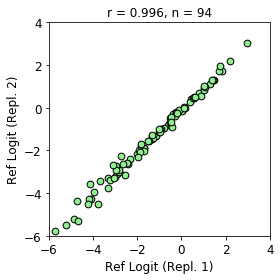

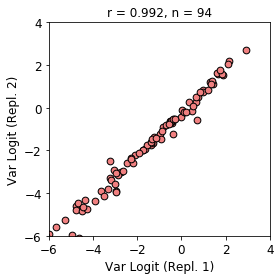

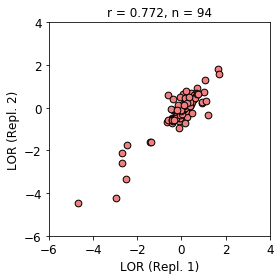

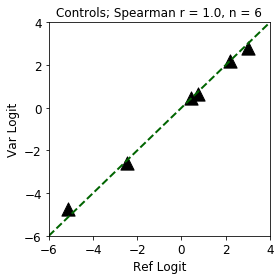

In [10]:
from scipy.stats import spearmanr

save_figs = True
fig_name = "replicate_hek293"

min_c = 5.

x_min = -6.
x_max = 4.

filtered_df = library_df.query("ref_count_total_repl_1 >= " + str(min_c) + " and " + "ref_count_total_repl_2 >= " + str(min_c) + " and " + "var_count_total_repl_1 >= " + str(min_c) + " and " + "var_count_total_repl_2 >= " + str(min_c))

print("len(filtered_df) = " + str(len(filtered_df)))

#Reference library (replicate correlation)
r_val_ref, _ = spearmanr(filtered_df['ref_logit_77_127_repl_1'], filtered_df['ref_logit_77_127_repl_2'])

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['ref_logit_77_127_repl_1'], filtered_df['ref_logit_77_127_repl_2'], color='lightgreen', s=45, edgecolor='black', linewidth=1)

plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Ref Logit (Repl. 1)", fontsize=12)
plt.ylabel("Ref Logit (Repl. 2)", fontsize=12)

plt.title("r = " + str(round(r_val_ref, 3)) + ", n = " + str(len(filtered_df)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_ref_logits.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_ref_logits.eps")

plt.show()

#Variant library (replicate correlation)
r_val_var, _ = spearmanr(filtered_df['var_logit_77_127_repl_1'], filtered_df['var_logit_77_127_repl_2'])

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['var_logit_77_127_repl_1'], filtered_df['var_logit_77_127_repl_2'], color='lightcoral', s=45, edgecolor='black', linewidth=1)

plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Var Logit (Repl. 1)", fontsize=12)
plt.ylabel("Var Logit (Repl. 2)", fontsize=12)

plt.title("r = " + str(round(r_val_var, 3)) + ", n = " + str(len(filtered_df)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_var_logits.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_var_logits.eps")

plt.show()

#Ref-Var library (delta replicate correlation)
r_val_var, _ = spearmanr(filtered_df['delta_logodds_true_77_127_repl_1'], filtered_df['delta_logodds_true_77_127_repl_2'])

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['delta_logodds_true_77_127_repl_1'], filtered_df['delta_logodds_true_77_127_repl_2'], color='lightcoral', s=45, edgecolor='black', linewidth=1)

plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("LOR (Repl. 1)", fontsize=12)
plt.ylabel("LOR (Repl. 2)", fontsize=12)

plt.title("r = " + str(round(r_val_var, 3)) + ", n = " + str(len(filtered_df)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_delta_logodds.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_delta_logodds.eps")

plt.show()

#Ref-Var control correlation
control_df = filtered_df.loc[filtered_df['experiment'].str.contains("control_") & filtered_df['data_source'].str.contains("Array_2019")]

r_val_control, _ = spearmanr(control_df['ref_logit_77_127_repl_pooled'], control_df['var_logit_77_127_repl_pooled'])

f = plt.figure(figsize=(4, 4))

plt.scatter(control_df['ref_logit_77_127_repl_pooled'], control_df['var_logit_77_127_repl_pooled'], color='black', s=175, marker='^')

plt.plot([x_min, x_max], [x_min, x_max], color='darkgreen', linestyle='--', linewidth=2,)

plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Ref Logit", fontsize=12)
plt.ylabel("Var Logit", fontsize=12)

plt.title("Controls; Spearman r = " + str(round(r_val_control, 3)) + ", n = " + str(len(control_df)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_control_logits.png", dpi=600, transparent=True)
    plt.savefig(fig_name + "_control_logits.eps")

plt.show()


n (sequences) = 186066


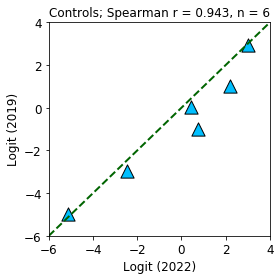

In [11]:
#Compare controls from 2022 oligo array to the Cell paper 2019 array

#Load oligo array from 2019
import isolearn.io as isoio

save_figs = True
fig_name = "replicate_hek293_to_2019"

isoform_pseudo_count = 1.
proximal_start = 77
proximal_end = 127

file_prefix = str(proximal_start) + "_" + str(proximal_end)

seq_dict = isoio.load('../../../../aparent/data/prepared_data/apa_array_data/apa_array_data_seq')

seq_df = seq_dict['array_df']
seq_cuts = seq_dict['pooled_cuts']

cut_true = np.concatenate([np.array(seq_cuts[:, 180: 180 + 205].todense()), np.array(seq_cuts[:, -1].todense()).reshape(-1, 1)], axis=-1)# - 1

seq_df['proximal_count'] = [np.sum(cut_true[i, proximal_start:proximal_end]) for i in range(len(seq_df))]
seq_df['total_count'] = [np.sum(cut_true[i, :]) for i in range(len(seq_df))]

seq_df['iso_true'] = (seq_df['proximal_count'] + isoform_pseudo_count) / (seq_df['total_count'] + 2. * isoform_pseudo_count)
seq_df['logodds_true'] = np.log(seq_df['iso_true'] / (1.0 - seq_df['iso_true']))

seq_df['seq'] = seq_df['seq'].str.slice(0, 205)

print("n (sequences) = " + str(len(seq_df)))

#Ref-Array 2019 control correlation
control_df_2019 = control_df.join(seq_df[['seq', 'logodds_true']].set_index("seq"), on='ref_seq', how='inner').copy().reset_index(drop=True)

r_val_control, _ = spearmanr(control_df_2019['ref_logit_77_127_repl_pooled'], control_df_2019['logodds_true'])

f = plt.figure(figsize=(4, 4))

plt.scatter(control_df_2019['ref_logit_77_127_repl_pooled'], control_df_2019['logodds_true'], color='deepskyblue', edgecolor='black', linewidth=1, s=175, marker='^')

plt.plot([x_min, x_max], [x_min, x_max], color='darkgreen', linestyle='--', linewidth=2,)

plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Logit (2022)", fontsize=12)
plt.ylabel("Logit (2019)", fontsize=12)

plt.title("Controls; Spearman r = " + str(round(r_val_control, 3)) + ", n = " + str(len(control_df_2019)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + ".png", dpi=600, transparent=True)
    plt.savefig(fig_name + ".eps")

plt.show()
